---
title: SPECTRAL ENERGY DISTRIBUTIONS OF T TAURI STARS WITH PASSIVE CIRCUMSTELLAR DISKS
subtitle: Learn how to blog in Academic using Jupyter notebooks
summary: Learn how to blog in Academic using Jupyter notebooks
authors:
- admin
tags: []
categories: []
date: "2019-02-05T00:00:00Z"
lastMod: "2019-09-05T00:00:00Z"
featured: false
draft: false

# Featured image
# To use, add an image named `featured.jpg/png` to your page's folder. 
#image:
#  caption: ""
#  focal_point: ""

# Projects (optional).
#   Associate this post with one or more of your projects.
#   Simply enter your project's folder or file name without extension.
#   E.g. `projects = ["internal-project"]` references 
#   `content/project/deep-learning/index.md`.
#   Otherwise, set `projects = []`.
projects: []
---

# SPECTRAL ENERGY DISTRIBUTIONS OF T TAURI STARS WITH PASSIVE CIRCUMSTELLAR DISKS
E. I. CHIANG & P. GOLDREICH (1997, ApJ)

AST501 -- theory project homework \
by Shih-Yun Tang 2021-09-04

In [1]:
import numpy as np
from astropy import constants as const
from astropy import units as u

import matplotlib
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
import matplotlib.pyplot as plt

import scipy.integrate as integrate
from pqdm.processes import pqdm
from functools import partial
from numba import njit

import warnings
warnings.filterwarnings('ignore')

## Basic parameters/functions setup

In [34]:


# -- Adopted stellar model parameters --
T_star = 4000                                               # staller effect temperature [K]
M_star = 0.5 * u.M_sun; M_star_cgs = M_star.to(u.g).value   # staller mass [g]
R_star = 2.5 * u.R_sun; R_star_cgs = R_star.to(u.cm).value  # staller radius [cm]

# -- Disk dusk grain pars --
grain_r   = 0.1  * u.um             ; grain_r_cgs   = grain_r.to(u.cm).value    # dusk grain radius [cm]
grain_den = 2.0  * u.g / u.cm**3    ; grain_den_cgs = grain_den.value       # dusk grain density [g / cm3]

a_inner = 0.07  * u.AU; a_inner_cgs  = a_inner.to(u.cm).value   # inner disk radius [cm]
a_outter= 2.7e2 * u.AU; a_outter_cgs = a_outter.to(u.cm).value  # outter disk radius [cm]

# dust_opacity = 400 * u.cm**2 / u.g
# dust_tau     = 4e5 * a

const_h         = const.h.to(u.erg * u.s).value                             # erg * s
const_kB        = const.k_B.to(u.erg / u.K).value                           # erg / K
const_c         = const.c.cgs.value                              # cm / s
const_sigma_sb  = const.sigma_sb.to(u.erg / (u.s * u.cm**2 * u.K**4)).value # erg / ( s * cm2 * K4 )
const_G         = const.G.cgs.value

cm2au = (1*u.cm).to(u.au).value

@njit
def BlackBody_nu(freq, temp, toFlux = True):
    """Planck func in nu

    Parameters
    ----------
    freq : float or array
        frequency [Hz]
    temp : float
        effective temperature [K]
    toFlux : bool, optional
        transfer from intensity to flux, by default True

    Returns
    -------
    float or array based on "freq"
        BB intensity or flux
    """
    
    log_boltz = const_h * freq / (const_kB * temp)
    boltzm1   = np.expm1(log_boltz)

    # Calculate blackbody
    bb_nu = 2.0 * const_h * freq ** 3 / (const_c ** 2 * boltzm1) # erg / (s * cm2 * Hz * sr)
        
    if toFlux:
        return bb_nu * np.pi   # erg / (s * cm2 * Hz)
    else:
        return bb_nu   # erg / (s * cm2 * Hz * sr)
    
    
def BB_nu_plot(plot_title):
    """Plotting function for all BB plots
    """
    _fontsize = 'small'
    fig, ax = plt.subplots(1, 1, figsize=(5,3.5), facecolor='white', dpi=150)

    ax.set_ylabel(r'log L$_\nu$ (L$_\ast$)', size=_fontsize, style='normal', family='sans-serif')
    ax.set_xlabel(r'log $\nu$ (Hz)',         size=_fontsize, style='normal', family='sans-serif')
    
    ax.set_xlim(11, 15); ax.set_ylim(-4.75, 0.25)
    ax.set_xticks(np.arange(11, 16))
    ax.xaxis.set_minor_locator(AutoMinorLocator(5))
    ax.yaxis.set_minor_locator(AutoMinorLocator(4))
    ax.tick_params(axis='both', which='both', labelsize=_fontsize, right=True, top=True, direction='in', width=0.5)

    um = (f_Hz*u.Hz).to(u.um, equivalencies=u.spectral())

    ax_c = ax.twiny()
    ax_c.set_xlim(um[0].value, um[-1].value)
    ax_c.tick_params(axis='x', which='both', labelsize=_fontsize, direction='in', width=0.5)
    ax_c.set_xscale('log')
    ax_c.set_xticks([1e3, 1e2, 1e1, 1e0])
    ax_c.set_xticklabels(['1000', '100', '10', '1'])
    ax_c.set_xlabel(r'$\lambda$ ($\rm \mu$m)', size=_fontsize, style='normal', family='sans-serif')

    ax.text(0.05, 0.90, plot_title, size=_fontsize, style='normal', family='sans-serif', transform = ax.transAxes )
    # ax.text(0.35, 0.15, r'Stellar Blackbody',   size=_fontsize, style='normal', family='sans-serif', transform = ax.transAxes )
    # ax.text(0.76, 0.50, r'Disk',                size=_fontsize, style='normal', family='sans-serif', transform = ax.transAxes )
    # ax.text(0.50, 0.60, r'Total',               size=_fontsize, style='normal', family='sans-serif', transform = ax.transAxes, ha='right' )
    
    return fig, ax
        

## Figure 1 -- Flat Blackbody Disk
Assuming the disk as a blackbody, the stellar radiation incident upon the flat disk is
$$
(\frac{\alpha}{2}) (\frac{R_\ast}{a})^2 \sigma T_\ast^4
$$
where $\alpha$ is the grazing angle.
> why $\alpha/2$ ??

With the emitting flux from the star ($flux = \sigma T_{eff}^4$) equals to the absorb flux, we get
$$
\sigma T_{eff}^4 = (\frac{\alpha}{2}) (\frac{R_\ast}{a})^2 \sigma T_\ast^4 \\
\Longrightarrow T_{eff}^4 = (\frac{\alpha}{2}) (\frac{R_\ast}{a})^2 T_\ast^4 \\
\Longrightarrow T_{eff} = (\frac{\alpha}{2})^{1/4} (\frac{R_\ast}{a})^{1/2} T_\ast \ \ \ \ \ \  (\rm {Eq.\ 1\ in\ paper})
$$

The Spectral Energy Distrbution (SED), here use the luminosity, of the disk is computed as
$$
L_\nu \equiv 4 \pi d^4 \nu F_\nu [erg/s] \sim 
4\pi \nu \int_{a_i}^{a_o} a \pi B_\nu(T_{eff}(a)) \,da \\
\Longrightarrow 4\pi^2 \nu \int_{a_i}^{a_o} a B_\nu(T_{eff}(a)) \,da \ \ \ \ \ \  (\rm {Eq.\ 2\ in\ paper})
$$
> $L_\nu = FA$ [erg/s/Hz], where $A = 4 \pi d^4$ \
> $B_\nu(T_{eff})$ gives the intensity if the blackbody at $T_{eff}$ [erg/s/cm2/Hz/sr] \
> Why $8\pi^2$ NOT $4\pi^2$?

With Eq.(2), as `python` function `disk_SED`, we can now plot Figure 1.

In [3]:
@njit
def _alpha(a, R_star, flard = False):
    """grazing angle

    Parameters
    ----------
    a : float
        disk radius [cm]
    R_star : float
        Star radius [cm]

    Returns
    -------
    float
        grazing angle
    """
    if not flard:
        return 0.4 * R_star/a
    else:
        return 0.4 * R_star/a + 0.18 * (2/7) * (a*cm2au)**(2/7)

@njit
def _Teff(a, R_star, T_star, flard = False):
    """get disk effective temperature

    Parameters
    ----------
    a : float
        disk radius [cm]
    R_star : float
        Star radius [cm]
    T_star : float
        Star effective temperature [K]

    Returns
    -------
    float
        disk effective temperature [K]
    """
    # print(_alpha(a, R_star, flard))
    term1 = ( _alpha(a, R_star, flard) / 2 )**(1/4) 
    term2 = (R_star / a)**0.5
    return term1 * term2 * T_star

flat_BB_intergral = lambda a, nu, R_star, T_star, flard : a * BlackBody_nu(nu, 
                                                               _Teff(a, R_star, T_star, flard),
                                                               False)

def disk_SED(a_i, a_o, R_star, T_star, flard, nu):
    """L_nu, right hand side of Chiang & Goldreich 1997's Equation 2. 
    The finction that generate the disk SED curve

    Parameters
    ----------
    a_i : astropy.unit
        Inner disk radius [cm]
    a_o : astropy.unit
        Outter disk radius [cm]
    R_star : astropy.unit
        Star radius [cm]
    T_star : astropy.unit
        Star effective temperature [K]
    nu : astropy.unit
        frequency

    Returns
    -------
    float
        L_nu, [W]
    """
    
    a_intergral = integrate.quad(flat_BB_intergral, a_i, a_o, args=(nu, R_star, T_star, flard) )[0]
     
    return 8 * np.pi**2 * nu * a_intergral

In [4]:
# --- setup parameters ---
f_Hz = np.logspace(11, 15, 1000) # generate Hz from 1e11 --> 1e15 Hz

# --- generate the BB curve for the star ---
starBB_flux = BlackBody_nu(f_Hz, T_star)   # erg / s / cm2 / Hz

# --- Luminosity for the star ---
L_star     = const_sigma_sb*T_star**4                               # erg / s / cm2 
L_star_cm2 = 4*np.pi * (R_star_cgs)**2 * const_sigma_sb*T_star**4   # erg / s

In [5]:
# --- loop through all frequency range ---

func_flat = partial(disk_SED, a_inner_cgs, a_outter_cgs, R_star_cgs, T_star, False)
Lv_flat = pqdm(f_Hz, func_flat, n_jobs=6)

func_flared = partial(disk_SED, a_inner_cgs, a_outter_cgs, R_star_cgs, T_star, True)
Lv_flared = pqdm(f_Hz, func_flared, n_jobs=6)

SUBMITTING | :   0%|          | 0/1000 [00:00<?, ?it/s]

PROCESSING | :   0%|          | 0/1000 [00:00<?, ?it/s]

COLLECTING | :   0%|          | 0/1000 [00:00<?, ?it/s]

SUBMITTING | :   0%|          | 0/1000 [00:00<?, ?it/s]

PROCESSING | :   0%|          | 0/1000 [00:00<?, ?it/s]

COLLECTING | :   0%|          | 0/1000 [00:00<?, ?it/s]

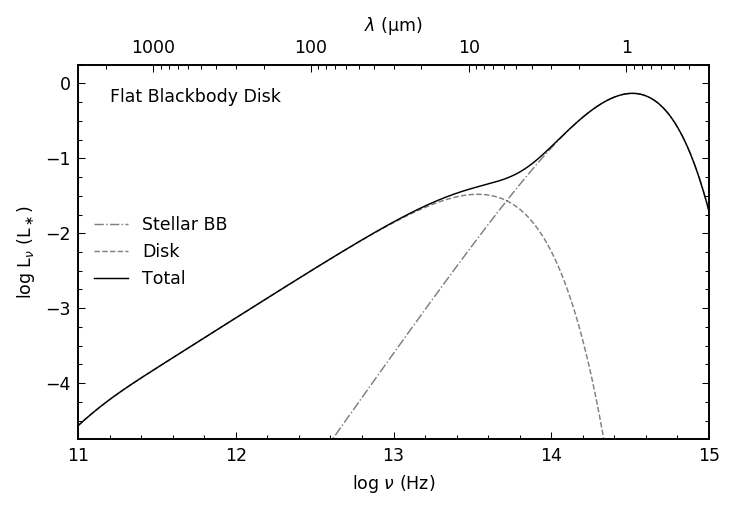

In [6]:
f2, ax = BB_nu_plot('Flat Blackbody Disk')
ax.plot(np.log10(f_Hz), np.log10(starBB_flux*f_Hz/L_star), '-.',  c = 'k', lw=0.7, label='Stellar BB',  alpha=.5)
ax.plot(np.log10(f_Hz), np.log10(Lv_flat/L_star_cm2),      '--',  c = 'k', lw=0.7, label='Disk',         alpha=.5)
ax.plot(np.log10(f_Hz), np.log10(Lv_flat/L_star_cm2 + starBB_flux*f_Hz/L_star),
                                                       '-',  c = 'k', lw=0.7, label='Total')
ax.legend(fontsize='small', edgecolor='none', loc='center left')

## Figure 2 -- Flared Blackbody Disk

The only change is the grazing angle, which is now in a more general form:
$$
\alpha \sim \frac{0.4 R_\ast}{a} + a \frac{d}{da}(\frac{H}{a})
$$
where H is the height of the visible disk photosphere above the disk midplane. Now, to solve $\frac{H}{a}$.
Assuming the gas is to be isothermal at temperature $T_{eff}$, i.e., in hydrostatic equalibrium, and only effected by the vertial gravity from the midplaine with $g_z = \omega^2 z$. We can write
$$
\frac{\partial p}{\partial z} = -g_z \rho
$$
where p is pressure, z is vertical height from the midplane, and $\rho$ is density.
Give the angle between incident point on the flared disk surface to the star and the disk midplane as $\theta$, we can get
$$
F = m g_z = \frac{GMm}{a^2} \sin{\theta} \\
\Longrightarrow g_z = \frac{GM}{a^2} \sin{\theta}
$$
With the small-angle approximation, $\sin{\theta} \sim \theta \sim \tan{\theta}$, we have $\sin{\theta} \sim z/a$, thus
$$
\frac{\partial p}{\partial z} = -g_z \rho \\
\Longrightarrow \frac{\partial p}{\partial z} = -\frac{GMz}{a^3} \rho   \ \ \ \ \ \  (3)
$$
Now with the ideal gas law, 
$$
pV = nRT \Longrightarrow p(\frac{m}{\rho}) = (\frac{m}{M_u}) (k_B N_A) T \\
\Longrightarrow \rho = \frac{p M_u}{k_B N_A T} = \frac{p \mu}{k_B T} 
$$
where $\mu$ is the gas mean molecular wright.
Now we can rewrite (3) as
$$
\frac{\partial p}{\partial z} = -\frac{GMz}{a^3} \frac{p \mu}{k_B T} \\
\Longrightarrow \frac{\partial p}{p} = -\frac{GM\mu}{a^3 k_B T} z\, \partial z
$$
Intergrate both size,
$$
\Longrightarrow \int_{p_0}^{p} \frac{\partial p}{p} = -\frac{GM\mu}{a^3 k_B T} \int_{0}^{z} z\, \partial z \\
\Longrightarrow \ln{\frac{p}{p_0}} = -\frac{GM\mu}{a^3 k_B T} \frac{1}{2}z^2 \\
\Longrightarrow p = p_0 \exp{- \frac{z^2}{2h^2}}
$$
where h, the scale height, is
$$
h = \sqrt{ \frac{k_B T a^3}{G M \mu} }   \ \ \ \ \ \  (\rm {Eq.\ 6\ in\ paper})
$$
With $E=k_B T$, the temperature ($T_c$) equivalent to the gravitational potential energy at the surface of the center star is
$$
T_c = \frac{G M_\ast \mu_g}{R_\ast k_B}\  (\rm {Eq.\ 8\ in\ paper})
$$


In [55]:
# --- estimating T_c ---
# mean molecular weight: with 73% of H and 26% of He
H_mass    = 0.73 * (1.00784  * u.u).cgs.value
He_mass   = 0.26 * (4.002602 * u.u).cgs.value

T_c = const_G * M_star_cgs * (H_mass+He_mass) / const_kB / R_star_cgs
print(fr'T_c ~ {T_c:1.1E} K. Close to that gave in the paper -> 8E+06 K')

T_c ~ 8.2E+06 K. Close to that gave in the paper -> 8E+06 K


With Eq. 6 & 8, we now know
$$
\frac{h}{a} = (\frac{T_{eff}}{T_c})^{1/2} (\frac{a}{R_\ast})^{1/2}\ \ \ \ \ \  (\rm {Eq.\ 7\ in\ paper})
$$

With Eq. 5 - 9, we know solve for $\frac{H}{a}$


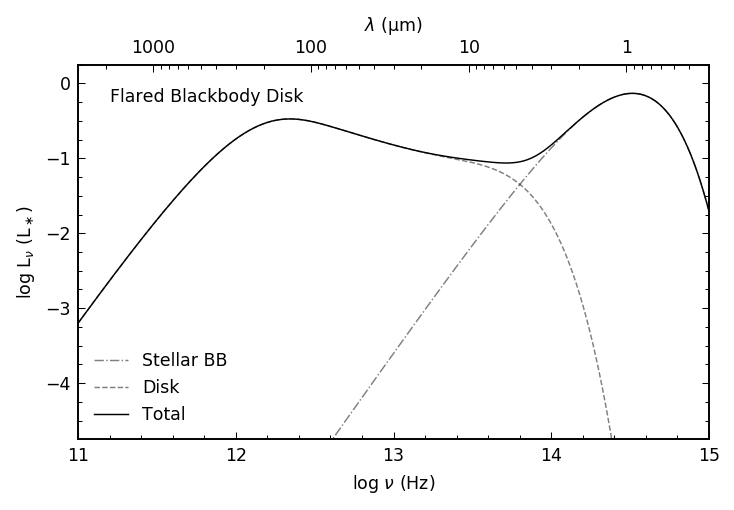

In [7]:
f1, ax = BB_nu_plot('Flared Blackbody Disk')
ax.plot(np.log10(f_Hz), np.log10(starBB_flux*f_Hz/L_star), '-.',  c = 'k', lw=0.7, label='Stellar BB',  alpha=.5)
ax.plot(np.log10(f_Hz), np.log10(Lv_flared/L_star_cm2),     '--',  c = 'k', lw=0.7, label='Disk',  alpha=.5)
ax.plot(np.log10(f_Hz), np.log10(Lv_flared/L_star_cm2 + starBB_flux*f_Hz/L_star),
                                                       '-',  c = 'k', lw=0.7, label='Total')
ax.legend(fontsize='small', edgecolor='none')

In [ ]:
Notes:
1. $\tau$ = $\kappa \rho$ s

def MMSN_sigma(a):
    """calculate disk surface mass density

    Parameters
    ----------
    a : astropy.unit
        disk radius, must be in AU

    Returns
    -------
    astropy.unit
        disk surface mass density [g/cm2]
    """
    if a.unit == 'AU':
        sigma0 = 1e3 * u.g/u.cm**2
        return a.value**(-1.5) * sigma0 
    else:
        raise Exception('disk radius a must be in astropy.units with AU')
    

def dust_tau(a):
    """calculate the optical depth, tau

    Parameters
    ----------
    a : astropy.unit
        disk radius, must be in AU

    Returns
    -------
    astropy.unit
        optical depth
    """
    if a.unit == 'AU':
        return 4e5 * a.value**(-1.5)
    else:
        raise Exception('disk radius a must be in astropy.units with AU')

def emissivity(lam, r):
    
    beta = 1
    if lam <= 2*np.pi*r:
        return 1
    elif lam > 2*np.pi*r:
        return (2*np.pi*r / lam) ** beta


def L_nu(nu):
    
    return 0.01 * (nu / 1e13)**(4/3)